## Mecab 설치
-형태소 분석기

In [1]:
!git clone https://github.com/SOMJANG/Mecab-ko-for-Google-Colab.git
%cd Mecab-ko-for-Google-Colab
!bash install_mecab-ko_on_colab190912.sh

Cloning into 'Mecab-ko-for-Google-Colab'...
remote: Enumerating objects: 115, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (20/20), done.
remote: Total 115 (delta 11), reused 10 (delta 3), pack-reused 91
Receiving objects: 100% (115/115), 1.27 MiB | 5.06 MiB/s, done.
Resolving deltas: 100% (50/50), done.
/content/Mecab-ko-for-Google-Colab
Installing konlpy.....
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 19.4 MB 1.2 MB/s 
     |████████████████████████████████| 453 kB 42.8 MB/s 
Done
Installing mecab-0.996-ko-0.9.2.tar.gz.....
from https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
--2022-10-13 00:14:35--  https://bitbucket.org/eunjeon/mecab-ko/downloads/mecab-0.996-ko-0.9.2.tar.gz
Resolving bitbucket.org (bitbucket.org)... 104.192.141.1, 2406:da00:ff00::22cd:e0db, 2406:da00:ff00::22c0:3470, ...
Connecting to bitbucket.org (bi

In [2]:
import re
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import urllib.request
from collections import Counter
from konlpy.tag import Mecab
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [3]:
urllib.request.urlretrieve("https://raw.githubusercontent.com/seunghak421/cp2-project/main/naver.txt", filename="ratings_total.txt")

('ratings_total.txt', <http.client.HTTPMessage at 0x7fb5ebffbd50>)

In [111]:
total_data = pd.read_table('ratings_total.txt', names=['평점', '리뷰'])
print('전체 리뷰 개수 :',len(total_data)) 

전체 리뷰 개수 : 200000


In [112]:
total_data[:5]

,평점,리뷰
0,5,배공빠르고 굿
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ


## 훈련데이터,테스트 데이터 분리


In [113]:
total_data['label'] = np.select([total_data.평점 >=4], [1], default=0) #평점이 4점이상이면 레이블1, 이하면 레아블 0 부여해서 label열에 저장
total_data[:10]

,평점,리뷰,label
0,5,배공빠르고 굿,1
1,2,택배가 엉망이네용 저희집 밑에층에 말도없이 놔두고가고,0
2,5,아주좋아요 바지 정말 좋아서2개 더 구매했어요 이가격에 대박입니다. 바느질이 조금 ...,1
3,2,선물용으로 빨리 받아서 전달했어야 하는 상품이었는데 머그컵만 와서 당황했습니다. 전...,0
4,5,민트색상 예뻐요. 옆 손잡이는 거는 용도로도 사용되네요 ㅎㅎ,1
5,2,비추합니다 계란 뒤집을 때 완전 불편해요 ㅠㅠ 코팅도 묻어나고 보기엔 예쁘고 실용적...,0
6,1,주문을 11월6에 시켰는데 11월16일에 배송이 왔네요 ㅎㅎㅎ 여기 회사측과는 전화...,0
7,2,넉넉한 길이로 주문했는데도 안 맞네요 별로예요,0
8,2,보폴이 계속 때처럼 나오다가 지금은 안나네요~,0
9,2,110인데 전문속옷브랜드 위생팬티105보다 작은듯해요. 불편해요. 밴딩부분이 다 신...,0


In [114]:
total_data['평점'].nunique(), total_data['리뷰'].nunique(), total_data['label'].nunique()

(4, 199908, 2)

중복 리뷰를 제외시키면 199908개 총 데이터는 20만개
중복 데이터 제거해줍니다

In [115]:
total_data.drop_duplicates(subset=['리뷰'], inplace=True) 

In [116]:
print('총 리뷰의 수 :',len(total_data))

총 리뷰의 수 : 199908


In [117]:
#결측치 확인
print(total_data.isnull().values.any())

False


훈련,테스트 데이터 3:1로 분리

In [118]:
train_data, test_data = train_test_split(total_data, test_size = 0.25, random_state = 42)
print('훈련용 리뷰 :', len(train_data))
print('테스트용 리뷰:', len(test_data))

훈련용 리뷰 : 149931
테스트용 리뷰: 49977


1,0으로 나는 레이블의 분포 확인

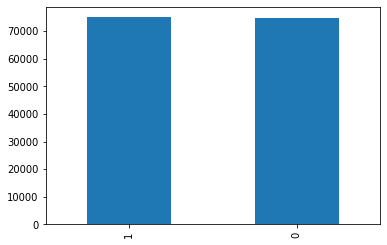

In [119]:
train_data['label'].value_counts().plot(kind = 'bar')

##데이터 정제
한글, 공백을 제외하고 모두 제거

In [120]:
train_data['리뷰'] = train_data['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") #^을 붙여주지 않으면 리뷰 데이터가 대부분 다 날라감
train_data['리뷰'].replace('', np.nan, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [121]:
print(train_data.isnull().sum())

평점       0
리뷰       0
label    0
dtype: int64


In [122]:
print('전처리 후 훈련데이터 :',len(train_data))

전처리 후 훈련데이터 : 149931


In [123]:
test_data['리뷰'] = test_data['리뷰'].str.replace("[^ㄱ-ㅎㅏ-ㅣ가-힣 ]","") 
test_data['리뷰'].replace('', np.nan, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version.
  """Entry point for launching an IPython kernel.


In [124]:
print('전처리 후 테스트데이터 :',len(test_data))

전처리 후 테스트데이터 : 49977


# 토큰화 

In [125]:
mecab = Mecab()
print(mecab.morphs('진짜이런쓰레기 같은 걸 파네'))


['진짜', '이런', '쓰레기', '같', '은', '걸', '파', '네']


불용어 지정

In [126]:
stopwords = ['은','는','이','가','을','를','듯','에','게','고','네요','하','도','과','네','임']


In [127]:
train_data['tokenized'] = train_data['리뷰'].apply(mecab.morphs)
train_data['tokenized'] = train_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

In [128]:
test_data['tokenized'] = test_data['리뷰'].apply(mecab.morphs)
test_data['tokenized'] = test_data['tokenized'].apply(lambda x: [item for item in x if item not in stopwords])

#단어의 분포 확인.
확인하면서 불필요해 보이는것 불용어에 추가


In [129]:
negative_words = np.hstack(train_data[train_data.label == 0]['tokenized'].values)
positive_words = np.hstack(train_data[train_data.label == 1]['tokenized'].values)

In [130]:
negative_word_count = Counter(negative_words)
print(negative_word_count.most_common(20))

[('는데', 20295), ('안', 19718), ('어요', 14849), ('있', 13200), ('너무', 13058), ('했', 11783), ('지', 11511), ('한', 10580), ('좋', 9812), ('배송', 9677), ('다', 9506), ('같', 8997), ('구매', 8876), ('어', 8869), ('거', 8854), ('없', 8670), ('아요', 8642), ('습니다', 8436), ('그냥', 8355), ('되', 8345)]


In [131]:
positive_word_count = Counter(positive_words)
print(positive_word_count.most_common(20))

[('좋', 39488), ('아요', 21184), ('어요', 18686), ('잘', 18602), ('구매', 16171), ('습니다', 13320), ('있', 12391), ('배송', 12275), ('는데', 11670), ('했', 9818), ('합니다', 9801), ('먹', 9635), ('재', 9273), ('너무', 8397), ('같', 7868), ('한', 7420), ('만족', 7261), ('거', 6482), ('어', 6294), ('쓰', 6292)]


#평균 길이 

In [132]:


text_len = train_data[train_data['label']==1]['tokenized'].map(lambda x: len(x))

print('긍정 리뷰의 평균 길이 :', np.mean(text_len))

text_len2 = train_data[train_data['label']==0]['tokenized'].map(lambda x: len(x))

print('부정 리뷰의 평균 길이 :', np.mean(text_len2))


긍정 리뷰의 평균 길이 : 13.663325023662566
부정 리뷰의 평균 길이 : 17.15626418217251


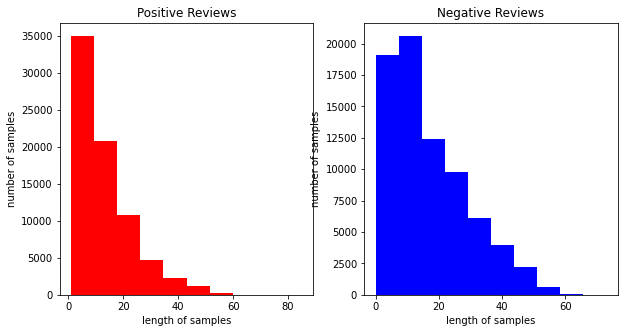

In [133]:
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(10,5))
ax1.hist(text_len, color='red')
ax1.set_title('Positive Reviews')
ax1.set_xlabel('length of samples')
ax1.set_ylabel('number of samples')



ax2.hist(text_len2, color='blue')
ax2.set_title('Negative Reviews')
ax2.set_xlabel('length of samples')
ax2.set_ylabel('number of samples')

plt.show()

긍정리뷰가 좀 더 짧은 경향이 있다.

#정수 인코딩

In [134]:
#단어집합 생성
X_train = train_data['tokenized'].values
y_train = train_data['label'].values
X_test= test_data['tokenized'].values
y_test = test_data['label'].values

In [135]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)

In [136]:
tokenizer.word_index

{'좋': 1,
 '어요': 2,
 '는데': 3,
 '아요': 4,
 '잘': 5,
 '있': 6,
 '구매': 7,
 '안': 8,
 '배송': 9,
 '습니다': 10,
 '했': 11,
 '너무': 12,
 '한': 13,
 '같': 14,
 '지': 15,
 '거': 16,
 '어': 17,
 '먹': 18,
 '합니다': 19,
 '다': 20,
 '되': 21,
 '재': 22,
 '요': 23,
 '기': 24,
 '쓰': 25,
 '않': 26,
 '없': 27,
 '것': 28,
 '아': 29,
 '해서': 30,
 '사용': 31,
 '로': 32,
 '았': 33,
 '들': 34,
 '나': 35,
 '으로': 36,
 '만': 37,
 '보다': 38,
 '었': 39,
 '주': 40,
 '겠': 41,
 '지만': 42,
 '보': 43,
 '아서': 44,
 '그냥': 45,
 '해': 46,
 '서': 47,
 '제품': 48,
 '면': 49,
 '어서': 50,
 '가격': 51,
 '해요': 52,
 '좀': 53,
 '만족': 54,
 '생각': 55,
 '주문': 56,
 '입니다': 57,
 '라': 58,
 '더': 59,
 '받': 60,
 '니': 61,
 '맛': 62,
 '할': 63,
 '많이': 64,
 '개': 65,
 '사': 66,
 '때': 67,
 '시': 68,
 '사이즈': 69,
 '에서': 70,
 '빠르': 71,
 '왔': 72,
 '샀': 73,
 '번': 74,
 '작': 75,
 '별로': 76,
 '음': 77,
 '맛있': 78,
 'ㅠㅠ': 79,
 '포장': 80,
 '입': 81,
 '수': 82,
 '두': 83,
 '맞': 84,
 '던': 85,
 '다른': 86,
 '저렴': 87,
 '괜찮': 88,
 '세요': 89,
 '넘': 90,
 '못': 91,
 '상품': 92,
 '정말': 93,
 '하나': 94,
 '아니': 95,
 '에요': 96,
 'ㅠ':

In [137]:
threshold = 2 #1번밖에 나오지 않은 단어를 골라내기 위해서 2로 

total_count = len(tokenizer.word_index) # 총단어의 수
rare_count = 0 # threshold보다 빈도수가 작은 단어의 수

total_freq = 0 #  전체 단어 빈도수 
rare_freq = 0 


for key, value in tokenizer.word_counts.items():
    total_freq = total_freq + value

    
    if(value < threshold):
        rare_count = rare_count + 1
        rare_freq = rare_freq + value

print('총 단어의 수  :',total_count)
print('등장 빈도가 %s번 이하인 단어의 수: %s'%(threshold - 1, rare_count))

print("빈도가 1인 단어의 수 :", (rare_count / total_count)*100)
print("전체 등장 빈도에서 등장빈도가 1인 단어의 비율 :", (rare_freq / total_freq)*100)

총 단어의 수  : 40004
등장 빈도가 1번 이하인 단어의 수: 18213
빈도가 1인 단어의 수 : 45.527947205279474
전체 등장 빈도에서 등장빈도가 1인 단어의 비율 : 0.7883596509453564


한번밖에 등장하지 않는 단어의 비율이 전체의 45%나 되는데
등장 빈도는 8%도 되지 않는다.
중요하지 않아보인다.

In [138]:
#제거
vocab_size = total_count - rare_count + 2
print(vocab_size)

21793


In [139]:
tokenizer = Tokenizer(vocab_size, oov_token = 'OOV') #Out-Of-Vocabulary
tokenizer.fit_on_texts(X_train)
X_train = tokenizer.texts_to_sequences(X_train)
X_test = tokenizer.texts_to_sequences(X_test)

In [140]:
print(X_train[:1])

[[70, 2066, 305, 14265, 269, 76, 5, 241, 173, 142, 811, 2957, 14, 631, 80, 65, 212, 43, 1349, 160, 2, 5]]


#패딩


리뷰 길이 시각화 

리뷰의 최대 길이 : 85
리뷰의 평균 길이 : 15.40868799647838


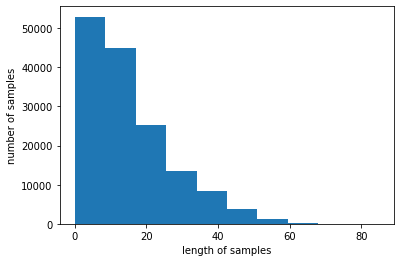

In [141]:
print('리뷰의 최대 길이 :',max(len(review) for review in X_train))
print('리뷰의 평균 길이 :',sum(map(len, X_train))/len(X_train))
plt.hist([len(review) for review in X_train])
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

In [142]:
def below_threshold_len(max_len, nested_list):
  count = 0
  for sentence in nested_list:
    if(len(sentence) <= max_len):
        count = count + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (count / len(nested_list))*100))

In [147]:
max_len = 70
below_threshold_len(max_len, X_train)

전체 샘플 중 길이가 70 이하인 샘플의 비율: 99.9979990795766


In [79]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)

GRU로 감성분류 (로직틱스회귀)


In [81]:
from tensorflow.keras.layers import Embedding, Dense, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

embedding_dim = 100
hidden_units = 128

model = Sequential()
model.add(Embedding(vocab_size, embedding_dim))
model.add(GRU(hidden_units))
model.add(Dense(1, activation='sigmoid'))

e_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=4)
save = ModelCheckpoint('best_model.h5', monitor='val_acc', mode='max', verbose=1, save_best_only=True)

model.compile(optimizer='rmsprop', loss='binary_crossentropy', metrics=['acc'])
history = model.fit(X_train, y_train, epochs=15, callbacks=[e_stop, save], batch_size=64, validation_split=0.2)

Epoch 1/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2725 - acc: 0.8972
Epoch 1: val_acc improved from -inf to 0.91703, saving model to best_model.h5
1875/1875 [==============================] - 307s 162ms/step - loss: 0.2725 - acc: 0.8972 - val_loss: 0.2298 - val_acc: 0.9170
Epoch 2/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2194 - acc: 0.9204
Epoch 2: val_acc improved from 0.91703 to 0.92397, saving model to best_model.h5
1875/1875 [==============================] - 304s 162ms/step - loss: 0.2194 - acc: 0.9204 - val_loss: 0.2130 - val_acc: 0.9240
Epoch 3/15
1875/1875 [==============================] - ETA: 0s - loss: 0.2016 - acc: 0.9274
Epoch 3: val_acc improved from 0.92397 to 0.92573, saving model to best_model.h5
1875/1875 [==============================] - 305s 163ms/step - loss: 0.2016 - acc: 0.9274 - val_loss: 0.2067 - val_acc: 0.9257
Epoch 4/15
1875/1875 [==============================] - ETA: 0s - loss: 0.1907 - acc: 0.9325
Epoch 4

저장된 모델중에 정확도가 높은 모델

In [85]:
loaded_model = load_model('best_model.h5')
print("\n 테스트 정확도: %.2f" % (loaded_model.evaluate(X_test, y_test)[1]))

1562/1562 [==============================] - 39s 25ms/step - loss: 0.2118 - acc: 0.9245

 테스트 정확도: 0.92


#새로운 리뷰 등록 예측

In [149]:
def review_predict(new_review):
  new_review = re.sub(r'[^ㄱ-ㅎㅏ-ㅣ가-힣 ]','', new_review) #정규 표현식
  new_review = mecab.morphs(new_review) #토큰화 
  new_review = [word for word in new_review if not word in stopwords] #불용어 제거 
  encoded = tokenizer.texts_to_sequences([new_review]) #정수 인코딩
  pad_new = pad_sequences(encoded, maxlen = max_len) #패딩

  score = float(loaded_model.predict(pad_new))
  if(score > 0.5):
    print("{:.2f}% 확률로 긍정 리뷰입니다.".format(score * 100))
  else:
    print("{:.2f}% 확률로 부정 리뷰입니다.".format((1 - score) * 100))

In [165]:
review_predict('진짜 개쓰레기 같네요...')

1/1 [==============================] - 0s 22ms/step
97.63% 확률로 부정 리뷰입니다.


In [166]:
review_predict('와...이딴걸 만들어서 판다니 놀라울뿐이네요')

1/1 [==============================] - 0s 22ms/step
95.06% 확률로 부정 리뷰입니다.


In [167]:
review_predict('사용한지 일주일만에 고장 났습니다')

1/1 [==============================] - 0s 23ms/step
98.48% 확률로 부정 리뷰입니다.


In [168]:
review_predict('환불 부탁드립니다')

1/1 [==============================] - 0s 24ms/step
99.41% 확률로 부정 리뷰입니다.


In [169]:
review_predict('ㅋㅋㅋㅋ시킨지 2주가 지났는데 아직도 안왔습니다. 판매자는 응답도 없고 사기인가요??')

1/1 [==============================] - 0s 22ms/step
98.20% 확률로 부정 리뷰입니다.


In [170]:
review_predict('고장도 안나고 튼튼하게 잘 사용할것 같아요')

1/1 [==============================] - 0s 22ms/step
98.29% 확률로 긍정 리뷰입니다.


In [171]:
review_predict('정성원 공룡 소갈비찜 맛있어요.')

1/1 [==============================] - 0s 24ms/step
94.38% 확률로 긍정 리뷰입니다.


In [172]:
review_predict('택배가 정말 빨리 도착했고 상품도 맘에 드네요')

1/1 [==============================] - 0s 22ms/step
97.72% 확률로 긍정 리뷰입니다.


In [173]:
review_predict('정말 좋은 상품 추천합니다')

1/1 [==============================] - 0s 22ms/step
95.07% 확률로 긍정 리뷰입니다.


In [174]:
review_predict('맘에 들어요 ')

1/1 [==============================] - 0s 23ms/step
86.68% 확률로 긍정 리뷰입니다.
